In [3]:
import numpy as np
import math
ONB_EPSILON = 0.01
import glob
import os
from tqdm.notebook import tqdm
from PIL import Image

In [4]:
def getPhi(x, y, z):
    value = math.degrees(math.atan2(math.sqrt(x**2+z**2), y))
    if value >= 0:
        return value 
    return (value+360)%360
def getTheta(x, y, z):
    value = math.degrees(math.atan2(z, x)) # x is the standard
    if value >= 0:
        return value 
    return (value+360)%360

def getX(radius, theta, phi):
    return radius * math.cos(theta*0.01745) * math.sin(phi*0.01745)

def getZ(radius, theta, phi):
    return radius * math.sin(theta*0.01745) * math.sin(phi*0.01745)

def getY(radius, theta, phi):
    return radius * math.cos(phi*0.01745)

def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0:
        return v
    return v / norm

def initFromU(u):
    n = np.array([0.0, 1.0, 0.0])
    m = np.array([0.0, 0.0, 1.0])

    U = normalize(u)
    V = np.cross(U, n);
    if (np.linalg.norm(V) < ONB_EPSILON):
        V = np.cross(U, m)
    W = np.cross(U,V)
    return U, V, W

def getLightAngles(light_pos, point, normal):
    light_dir = light_pos-point
    light_pos = light_pos/np.linalg.norm(light_pos)
    
def localToWorld(point, normal):
    transformation_matrix = np.zeros((4,4))
    
    # Initialize fourth column of viewing matrix
    transformation_matrix[:, 3] = np.append(point, 1)
    
    #Initialize first three columns of viewing matrix
    
    right, newup, dir = initFromU(normal)
    
    transformation_matrix[:, 0] = np.append(right, 0)
    transformation_matrix[:, 1] = np.append(newup, 0) # check with (-) sign
    transformation_matrix[:, 2] = np.append(dir, 0)
    
    return transformation_matrix, np.linalg.inv(transformation_matrix)

In [48]:
face_file = np.loadtxt('face_writer.txt', delimiter=', ')
point_data = face_file[:, 4:7]
#point_data = [i/np.linalg.norm(i) for i in point_data] # Optional normalization

In [49]:
point_angles = [[getPhi(i[0], i[1], i[2]), getTheta(i[0], i[1], i[2])] for i in point_data]

In [50]:
a = np.zeros((180,360,3))

In [51]:
image_file = np.array(Image.open('new_exp.png'))
for i in tqdm(range(len(face_file))):
    x, y, phi, theta = face_file[i][0], face_file[i][1], point_angles[i][0], point_angles[i][1]
    a[int(phi)][int(theta)] = image_file[int(x)][int(y)]
    

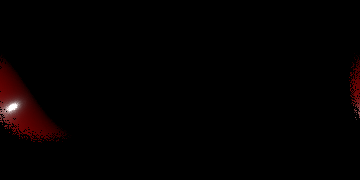

In [52]:
display(Image.fromarray(np.uint8(a)))

In [24]:
b, c = localToWorld([-0.205153, 2.677684, 0.171068], [-0.341426, 0.900588, 0.269014])
b, c

(array([[-0.34142617,  0.        , -0.88342817, -0.205153  ],
        [ 0.90058845,  0.26901414, -0.30748447,  2.677684  ],
        [ 0.26901414, -0.90058845, -0.09184847,  0.171068  ],
        [ 0.        ,  0.        ,  0.        ,  1.        ]]),
 array([[-3.41426172e-01,  9.00588454e-01,  2.69014136e-01,
         -2.52755561e+00],
        [-1.93447578e-18,  3.04511612e-01, -1.01942465e+00,
         -6.40994934e-01],
        [-1.00000000e+00, -3.48058257e-01, -1.03968234e-01,
          7.44622664e-01],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00]]))

In [27]:
np.matmul(c, [-3.5386047483649463, 9.336052028716171, 0.5625024017315149, 1])

array([7.23987843, 1.6285125 , 0.97525503, 1.        ])

In [26]:
getX(10, 171, 21), getY(10, 171, 21), getZ(10, 171, 21)

In [28]:
getPhi(7.23987843, 1.6285125 , 0.97525503), getTheta(7.23987843, 1.6285125 , 0.97525503)

(77.43293649815394, 7.671903408108093)

In [44]:
all_images = glob.glob('../sample_pbrt/images/*.png')
image_data = np.zeros((180,360,3))
for i in tqdm(range(len(all_images))):
    image = all_images[i]
    np_img = np.array((Image.open(image)).convert('RGB'))
    file_name = os.path.basename(image)
    name, ext = os.path.splitext(file_name)
    phi, theta = int(name.split('_')[1]), int(name.split('_')[3])
    image_data[(phi-1), (theta-1)] = np_img[1,0,:]
    

In [23]:
a = Image.fromarray(np.uint8(image_data)).resize((72*30, 36*30))

In [45]:
big_one = Image.fromarray(np.uint8(image_data))
big_one.save('big_one.tga')

In [17]:
b = np.array(Image.open('big_one.tga'))

In [21]:
(b[:, :, 2]>0).sum()/(360*180)

0.020339506172839507

In [33]:
mask = np.zeros((180,360))

for i in range(180):
    for j in range(360):
        if(image_data[i][j].all() == 0):
            mask[i][j] = 255

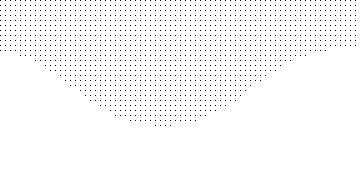

In [34]:
display(Image.fromarray(np.uint8(mask)))

In [35]:
from skimage.restoration import inpaint
image_result = inpaint.inpaint_biharmonic(image_data, mask, multichannel=True)

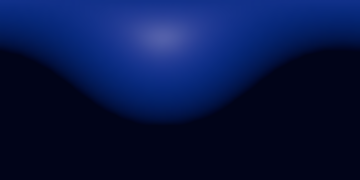

In [37]:
display(Image.fromarray(np.uint8(image_result)))

In [39]:
Image.fromarray(np.uint8(image_result)).save('inpainted.tga')